# Modeling coronva virus in Germany

Fit a very simple infection model and compare it to the current numbers of Germany.

First run `git clone https://github.com/CSSEGISandData/COVID-19.git && cd COVID-19`

In [1]:
!date

Sa 7. Mär 18:02:59 CET 2020


<div class="alert alert-block alert-info"><b>Note:</b> This uses a very simple model (SIR model) and assumes that no further measures will be taken to curb spread of the virus. The model's infection rate is just fitted visually, the recovery rate is set to 1/21 (3 weeks average).</div>

## imports

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%pylab inline

from itertools import chain

import numpy as np
from scipy.integrate import odeint
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [3]:
plt.style.use('seaborn')
FS = 16  # font size

## load current data

In [4]:
!git pull origin master

From https://github.com/CSSEGISandData/COVID-19
 * branch            master     -> FETCH_HEAD
Already up to date.


In [5]:
df = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [6]:
df = df.rename(columns={'Country/Region': 'country'})

In [7]:
df = df.query('country=="Germany"')

In [8]:
df = df.T.tail(-4).reset_index()

In [9]:
df = df.assign(date=pd.to_datetime(df['index']))

In [10]:
df = df.rename(columns={53: 'cases'})

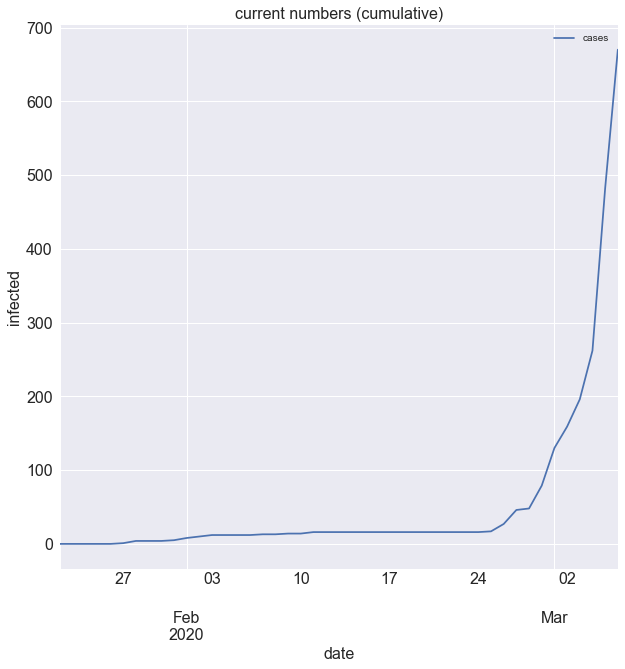

In [11]:
ax = df.plot(x='date', y='cases', figsize=(10, 10), fontsize=FS)
ax.set_xlabel('date', fontsize=FS)
ax.set_ylabel('infected', fontsize=FS)
ax.set_title('current numbers (cumulative)', fontsize=FS);

## model

Simple SIR model, see: https://en.wikipedia.org/wiki/Mathematical_modelling_of_infectious_disease

Model code from here: https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

In [12]:
# Total population, N.
N = 80000000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta = 7 / 21
gamma = 1. / 21
# A grid of time points (in days)
t = np.arange(200)

In [13]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [14]:
# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

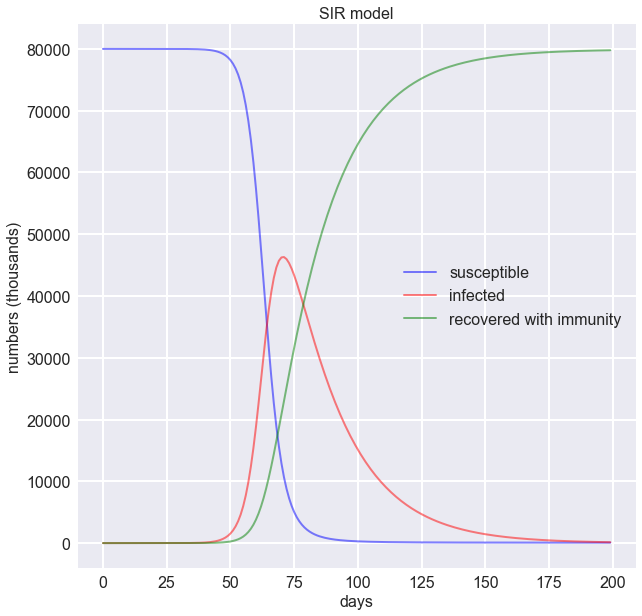

In [15]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='recovered with immunity')
ax.set_xlabel('days', fontsize=FS)
ax.set_ylabel('numbers (thousands)', fontsize=FS)
ax.set_title('SIR model', fontsize=FS)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(fontsize=FS)
legend.get_frame().set_alpha(0.5)
for tick in chain(ax.xaxis.get_major_ticks(), ax.yaxis.get_major_ticks()):
    tick.label.set_fontsize(FS)

## comparison

### "fit" real and model

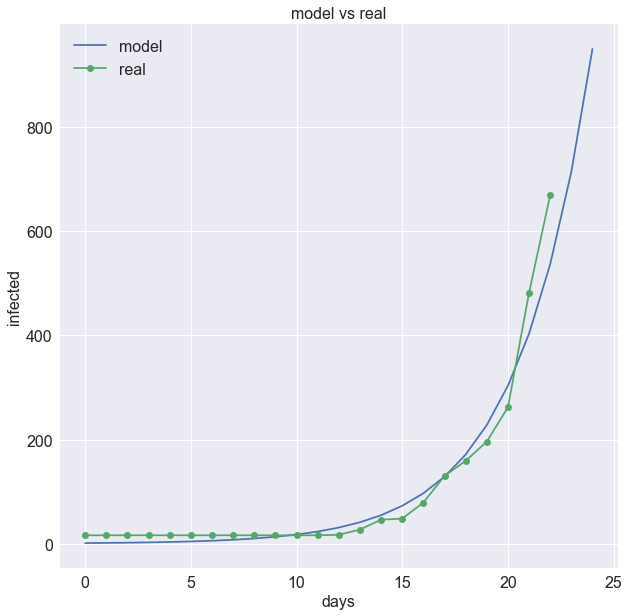

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(I[:25], label='model')
ax.plot(df['cases'][22:].values, marker='o', label='real')
ax.legend(fontsize=FS)
ax.set_xlabel('days', fontsize=FS)
ax.set_ylabel('infected', fontsize=FS)
ax.set_title('model vs real', fontsize=FS)
for tick in chain(ax.xaxis.get_major_ticks(), ax.yaxis.get_major_ticks()):
    tick.label.set_fontsize(FS)

### project numbers

In [17]:
current = df['cases'].values[-1]
print("current number of infected: {}".format(current))

current number of infected: 670


In [18]:
# where are we now in the model?
idx = np.argmin(abs(I - current))

In [19]:
print("maximum number of infected: {}, reached in {} days".format(int(max(I)), np.argmax(I) - idx))

maximum number of infected: 46304033, reached in 48 days


In [20]:
print("21 days projection", end="\n\n")
for i, infected in enumerate(I[idx - 1:idx + 22], start=-1):
    print(f"day {i:>2}: {int(infected): >10}")

21 days projection

day -1:        536
day  0:        714
day  1:        950
day  2:       1265
day  3:       1683
day  4:       2240
day  5:       2980
day  6:       3966
day  7:       5278
day  8:       7023
day  9:       9345
day 10:      12436
day 11:      16547
day 12:      22018
day 13:      29296
day 14:      38978
day 15:      51857
day 16:      68987
day 17:      91767
day 18:     122052
day 19:     162305
day 20:     215784
day 21:     286798
